<a href="https://colab.research.google.com/github/patdring/GenerativeAI/blob/main/handwritten_digit_generation_gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generative Adversarial Networks (GANs) for MNIST Digit Generation

This notebook demonstrates the use of Generative Adversarial Networks (GANs) to generate images of handwritten digits similar to those found in the MNIST dataset. The GAN consists of two neural networks: a Generator and a Discriminator. The Generator creates fake images, while the Discriminator attempts to distinguish between real and fake images. Through a process of adversarial training, the Generator improves its ability to create realistic images.

Key components:
- **Generator**: A neural network that generates new images from random noise.
- **Discriminator**: A neural network that classifies images as real or fake.
- **Adversarial Loss**: The loss function used to train both networks.

Training involves alternating between updating the Discriminator and the Generator to improve their respective performance.

**Visualization**: The notebook also includes a visualization of the generated images for each digit from 0 to 9.

In [ ]:
!pip install torch torchvision matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

Using device: cuda:0
[Epoch 1/10] [Batch 0/469] [D loss: 0.5940276384353638] [G loss: 0.7145419120788574]
[Epoch 1/10] [Batch 10/469] [D loss: 0.5571435689926147] [G loss: 0.5940417051315308]
[Epoch 1/10] [Batch 20/469] [D loss: 0.34046462178230286] [G loss: 1.0019289255142212]
[Epoch 1/10] [Batch 30/469] [D loss: 0.30323198437690735] [G loss: 0.8735978603363037]
[Epoch 1/10] [Batch 40/469] [D loss: 0.2645202875137329] [G loss: 1.0450656414031982]
[Epoch 1/10] [Batch 50/469] [D loss: 0.23343199491500854] [G loss: 1.1968188285827637]
[Epoch 1/10] [Batch 60/469] [D loss: 0.21283966302871704] [G loss: 1.2103257179260254]
[Epoch 1/10] [Batch 70/469] [D loss: 0.2023048847913742] [G loss: 1.3260538578033447]
[Epoch 1/10] [Batch 80/469] [D loss: 0.21102632582187653] [G loss: 1.4268856048583984]
[Epoch 1/10] [Batch 90/469] [D loss: 0.22277109324932098] [G loss: 1.4754784107208252]
[Epoch 1/10] [Batch 100/469] [D loss: 0.23499390482902527] [G loss: 1.5171570777893066]
[Epoch 1/10] [Batch 110/46

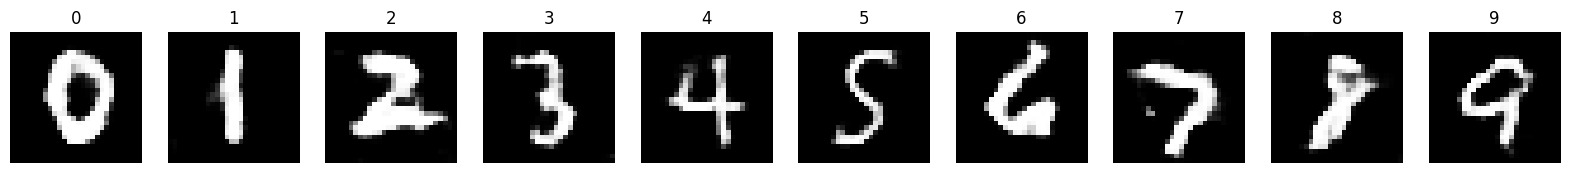

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.Resize(28),          # Resize images to 28x28 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize images with mean and std deviation of 0.5
])

# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.init_size = 28 // 4
        self.l1 = nn.Sequential(nn.Linear(nz + 10, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.LayerNorm([128, self.init_size, self.init_size]),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LayerNorm([128, 14, 14]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.LayerNorm([64, 28, 28]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, nc, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        labels = self.label_emb(labels)
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.expand(-1, -1, noise.size(2), noise.size(3))
        gen_input = torch.cat((labels, noise), 1)
        out = self.l1(gen_input.view(gen_input.size(0), -1))
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(784 + 10, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), dim=1)
        validity = self.model(d_in)
        return validity

# Hyperparameters
nz = 100  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
nc = 1    # Number of channels in the training images (MNIST is grayscale, so 1 channel)

# Create the generator and discriminator
generator = Generator(nz, ngf, nc).to(device)
discriminator = Discriminator(ndf, nc).to(device)

# Set up optimizers for both G and D
optimizer_G = optim.SGD(generator.parameters(), lr=0.001)
optimizer_D = optim.SGD(discriminator.parameters(), lr=0.01)

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop
n_critic = 5  # Number of discriminator updates per generator update
for epoch in range(50):
    for i, (imgs, labels) in enumerate(dataloader):
        # Train Discriminator
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            valid = torch.ones(imgs.size(0), 1, device=device, requires_grad=False)
            fake = torch.zeros(imgs.size(0), 1, device=device, requires_grad=False)

            real_pred = discriminator(imgs.to(device), labels.to(device))
            real_loss = adversarial_loss(real_pred, valid)

            z = torch.randn(imgs.size(0), nz, 1, 1, device=device)
            gen_labels = torch.randint(0, 10, (imgs.size(0),), device=device)
            gen_imgs = generator(z, gen_labels)

            fake_pred = discriminator(gen_imgs.detach(), gen_labels)
            fake_loss = adversarial_loss(fake_pred, fake)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), nz, 1, 1, device=device)
        gen_labels = torch.randint(0, 10, (imgs.size(0),), device=device)
        gen_imgs = generator(z, gen_labels)

        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        # Print losses
        if (i % 10 == 0):
            print(f"[Epoch {epoch+1}/10] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Generate and visualize some images
fixed_noise = torch.randn(10, nz, 1, 1, device=device)
labels = torch.arange(0, 10, device=device).long()
with torch.no_grad():
    generated_images = generator(fixed_noise, labels).detach().cpu()

generated_images = (generated_images + 1) / 2

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].squeeze(), cmap='gray')
    ax.set_title(str(i))
    ax.axis('off')
plt.show()